Python sources: https://github.com/MatrixNorm/kaggle/tree/master/python_sources/kaggle/house_prices


Original R notebook: https://nbviewer.jupyter.org/github/MatrixNorm/kaggle/blob/master/rbooks/house_prices/01_first_look.ipynb

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext rpy2.ipython

In [58]:
import numpy as np
import pandas as pd

from rpy2 import robjects
from rpy2.robjects.lib import ggplot2

from kaggle.house_prices.notebook import (
    HTML, Plot, show_table, show_list, show_list_html, inject_css)

inject_css()

# Fixing rpy2 library

Library rpy2 needs a fix:
* https://bitbucket.org/rpy2/rpy2/issues/398/pandas2ri-conversion-does-not-work-for    
* https://bitbucket.org/rpy2/rpy2/commits/6507a43d2793
   
```
- res.rclass = StrSexpVector('ordered', 'factor')
+ res.rclass = StrSexpVector(('ordered', 'factor'))

```

In [3]:
# should be no error
category = pd.Series(pd.Categorical(['a','b','c','a'],
                     categories=['a','b','c'],
                     ordered=True))
robjects.conversion.py2ro(category)

a,b,c,a


# Remark #1: Group by and missing values

Dplyr's grouping&summarising does not throw away NA group, while in pandas it do.

Workaround is it to fill NA values with some designated value like `__missing__` or whatever.

In [4]:
%%R

library(dplyr, warn.conflicts=FALSE)

df <- tribble(
    ~categ, ~numer,
     'a',    1,
     'a',    2,
     'b',    3,
     NA,     4,
     NA,     5
)

# in dplyr NA is treated as a group
df %>% 
group_by(categ) %>% 
summarise(mean = mean(numer))

# A tibble: 3 x 2
  categ  mean
  <chr> <dbl>
1     a   1.5
2     b   3.0
3  <NA>   4.5


In [5]:
df = pd.DataFrame(
    [
        ('a',    1),
        ('a',    2),
        ('b',    3),
        (np.NaN, 4),
        (np.NaN,    5)
    ], 
    columns=['categ', 'numer']
)

# not in Python
show_table(
    df.groupby('categ').agg({'numer': np.mean}).reset_index(), 
    df.fillna('__missing__').groupby('categ').agg({'numer': np.mean}).reset_index()
)

,categ,numer
0,a,1.5
1,b,3.0
,categ,numer
0,__missing__,4.5
1,a,1.5
2,b,3.0


In [70]:
import kaggle.house_prices.helpers as helpers

# load data
combined_dataset = helpers.load_data()

HTML("".join([
    show_list_html(combined_dataset.shape, cap="combined"),
    show_list_html(combined_dataset[combined_dataset['dataSource'] == 'train'].shape, cap="train"),
    show_list_html(combined_dataset[combined_dataset['dataSource'] == 'test'].shape, cap="test"),
]))

In [71]:
character_colnames = helpers.get_character_colnames(combined_dataset)
numeric_colnames = helpers.get_numeric_colnames(combined_dataset)

show_list(character_colnames, cap="Categorical predictors")
show_list(numeric_colnames, cap="Numeric predictors")

In [75]:
# replace NA in categorical columns with `__missing__`
# see remark #1 about NAs in pandas
categ_data = combined_dataset[character_colnames].fillna('__missing__')
categ_data['SalePrice'] = combined_dataset['SalePrice']
categ_data['Id'] = combined_dataset['Id']

numeric_data = combined_dataset[numeric_colnames].copy()
numeric_data['Id'] = combined_dataset['Id']

HTML("".join([
    show_list_html(categ_data.shape, cap="categ"),
    show_list_html(numeric_data.shape, cap="numeric")
]))

# "Normal Paper" applied to SalePrice

,var,value,normed_value
1169,price,625000.000000,5.589940
1182,price,745000.000000,7.100466
691,price,755000.000000,7.226343
2629,price_log,13.345507,3.308173
2642,price_log,13.521139,3.747857
2151,price_log,13.534473,3.781237


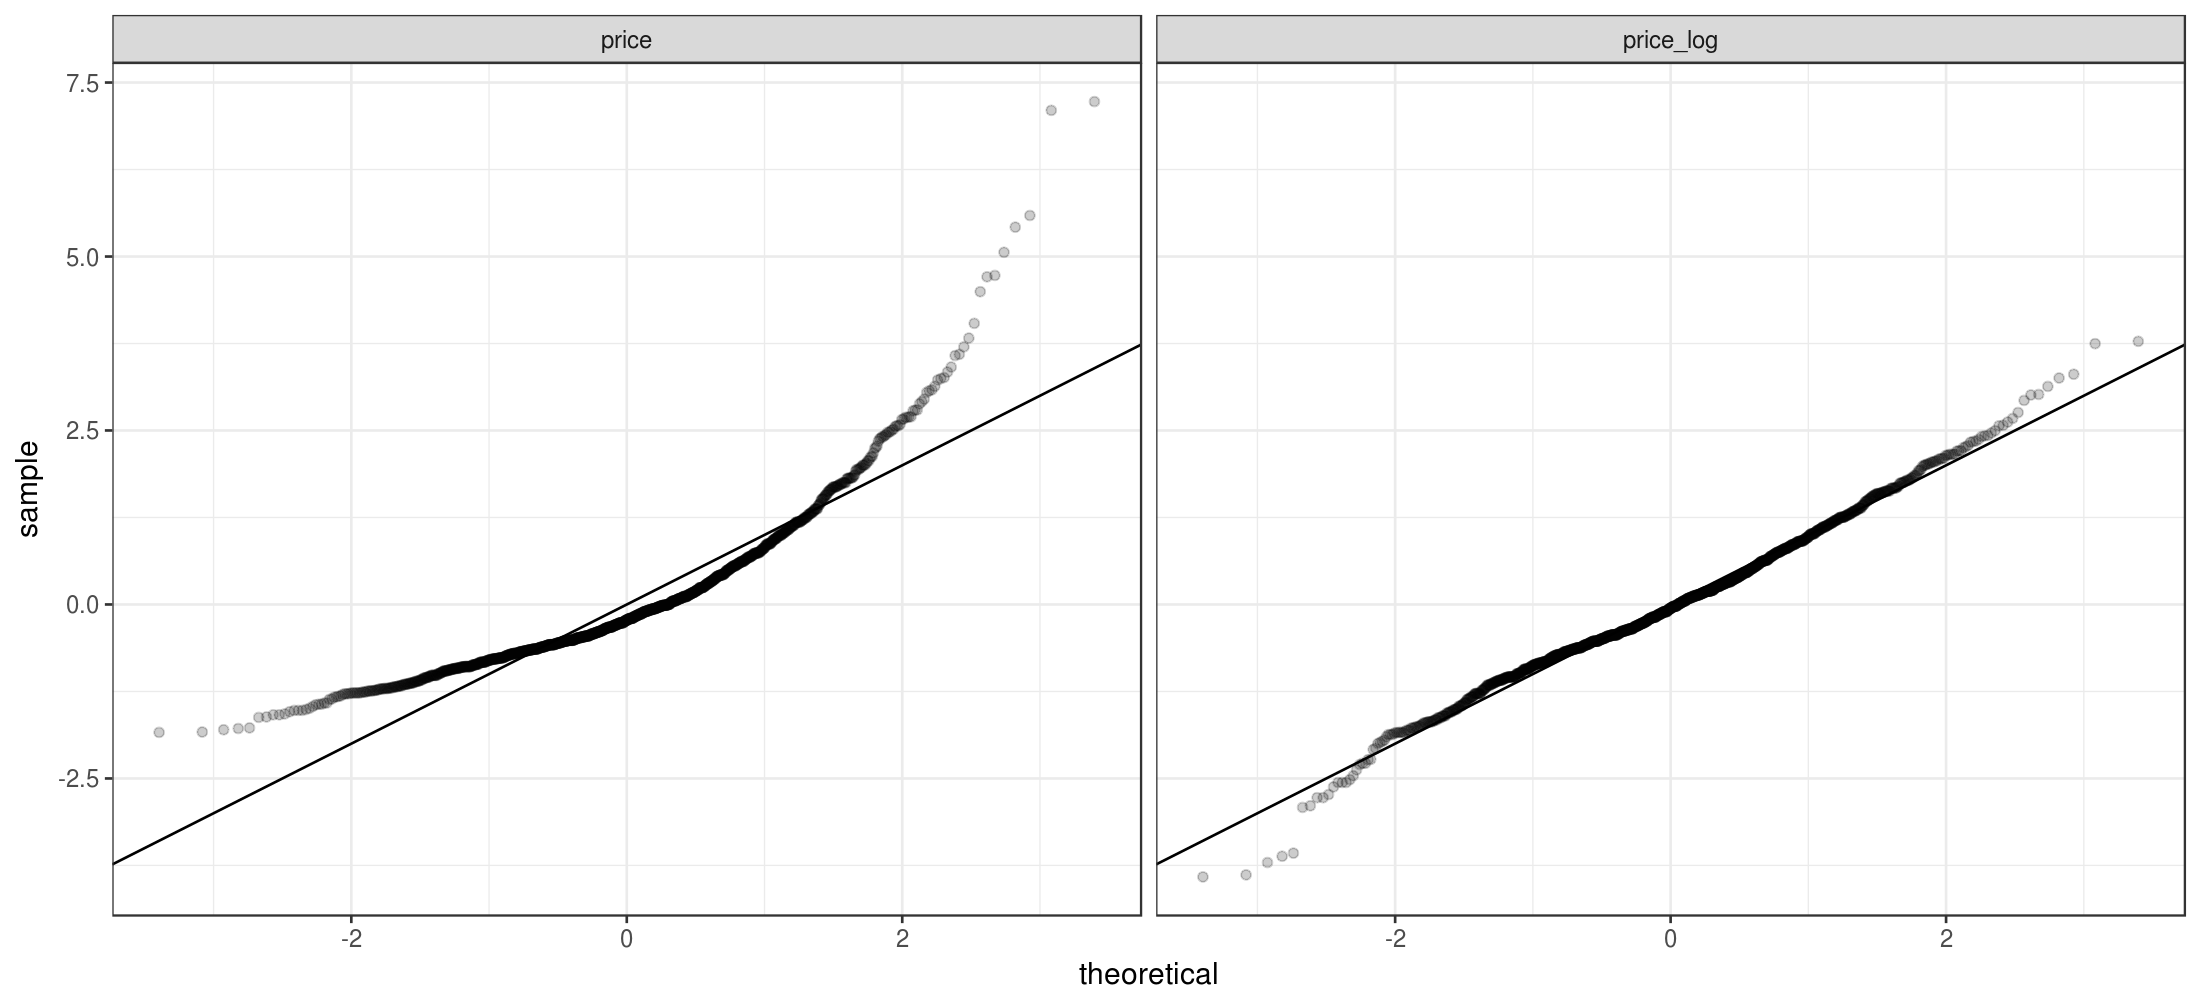

In [77]:
target_normal_paper = pd.melt(
    (
        combined_dataset[['SalePrice']]
        .dropna()
        .rename(
            columns={"SalePrice": "price"}
        )
        .assign(
            price_log = lambda df: np.log(df['price'])
        )
    ), 
    var_name='var', 
    value_name='value'
).assign(
    normed_value = lambda df: (
        df.groupby('var', group_keys=False)
          .apply(
              lambda df: (df.value - np.mean(df.value)) / np.std(df.value, ddof=1)
          )
    )
)

(target_normal_paper
    .sort_values(['var', 'value'])
    .groupby('var')
    .tail(3)
)

with Plot(width=2200, height=1000, res=180) as plot:
    plot(
        ggplot2.ggplot(target_normal_paper) +
        ggplot2.stat_qq(ggplot2.aes_string(sample='normed_value'), alpha=0.2) +
        ggplot2.facet_wrap(robjects.Formula('~var'), ncol=2) +
        ggplot2.geom_abline(slope=1) +
        ggplot2.theme_bw()
    )    

# Entropy

In [57]:
from kaggle.house_prices import attributes_selection as attr_sel

categ_vars_by_entropy = attr_sel.arrange_vars_by_entropy(categ_data.drop('SalePrice', 1))
numeric_vars_by_entropy = attr_sel.arrange_vars_by_entropy(numeric_data.drop('SalePrice', 1))

show_table(
    categ_vars_by_entropy.head(), 
    categ_vars_by_entropy.tail(),
    numeric_vars_by_entropy.head(), 
    numeric_vars_by_entropy.tail()
)

,var,entropy
0,Utilities,0.012627
1,PoolQC,0.038203
2,Street,0.038504
3,Condition2,0.106434
4,RoofMatl,0.138519
,var,entropy
40,Exterior1st,2.723429
41,Exterior2nd,2.800720
42,MSSubClass,2.920021
43,MoSold,3.393870


# Separation between groups

In [65]:
groups_separation = attr_sel.GroupsSeparation(categ_data, 'SalePrice')
precalculated = groups_separation.get_precalculated()

precalculated.head(5)

categ_vars_by_groups_separation = groups_separation.arrange_vars()

show_table(
    categ_vars_by_groups_separation.head(6), 
    categ_vars_by_groups_separation.tail(6)
)

,var,value,n,mean,std,freq,lead_mean,lead_freq,lead_std
0,Alley,Grvl,50.0,122219.080000,34780.780734,0.034247,168000.585366,0.028082,38370.375243
1,Alley,Pave,41.0,168000.585366,38370.375243,0.028082,183452.131483,0.937671,80667.145180
2,Alley,__missing__,1369.0,183452.131483,80667.145180,0.937671,NaN,NaN,NaN
4,BldgType,2fmCon,31.0,128432.258065,35458.545158,0.021233,133541.076923,0.035616,27833.249197
5,BldgType,Duplex,52.0,133541.076923,27833.249197,0.035616,135911.627907,0.029452,41013.222080


,var,score
0,Utilities,0.000205
1,LotConfig,0.000507
2,Functional,0.000648
3,MoSold,0.000716
4,PoolQC,0.001066
5,Condition2,0.001223
,var,score
39,BsmtFinType1,0.121116
40,CentralAir,0.204230
41,GarageFinish,0.275604


### Visualising separation by two opposite cases

In [66]:
# Helper function that orderes factor levels by SalePrice's mean value at that level.
# Otherwise ggplot will by default order levels lexicographically.

attr_sel.order_factor_by_target(
    categ_data.dropna(subset=['SalePrice'])[['ExterQual', 'SalePrice']], 
    factor_var='ExterQual', 
    target_var='SalePrice'
)['ExterQual'].dtype

CategoricalDtype(categories=['Fa', 'TA', 'Gd', 'Ex'], ordered=True)

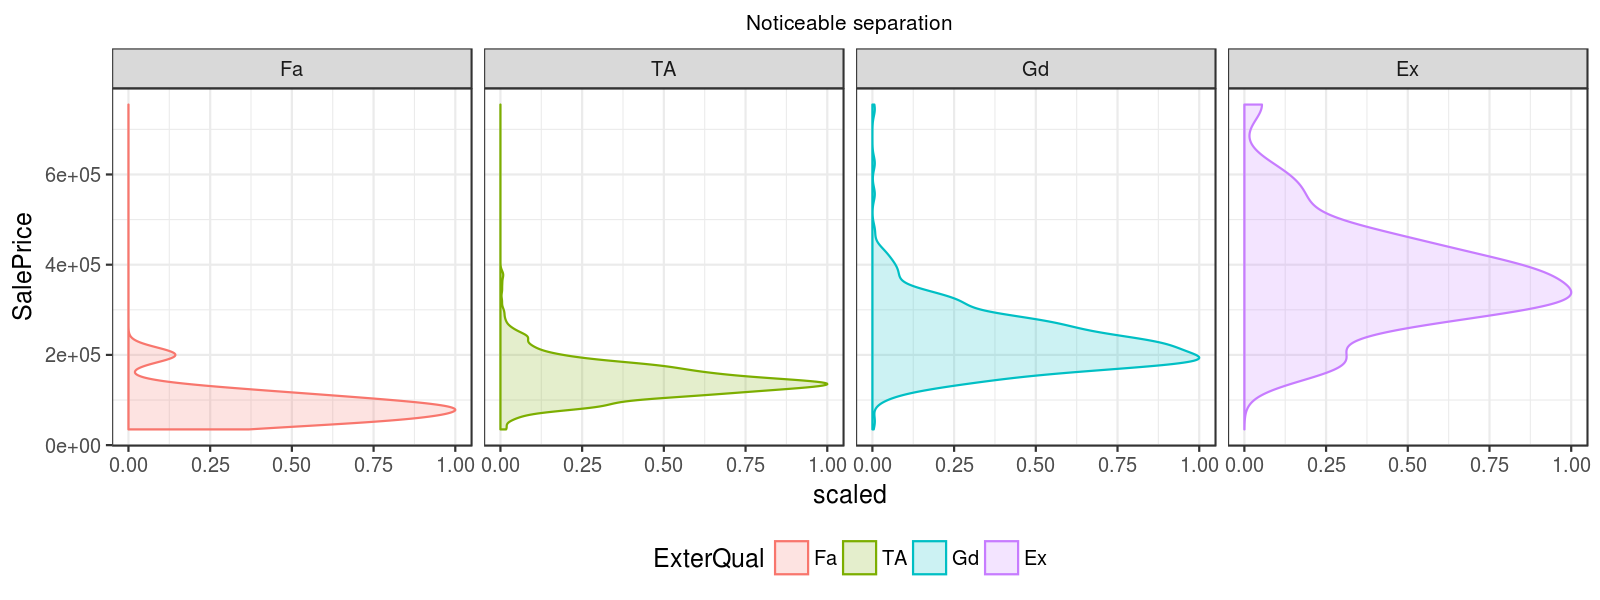

In [74]:
df = attr_sel.order_factor_by_target(categ_data, factor_var='ExterQual', target_var='SalePrice')

with Plot(width=1600, height=600, res=150) as plot:
    plot(
        ggplot2.ggplot(df) +
        ggplot2.aes_string(x='SalePrice', color='ExterQual') +
        ggplot2.geom_density(ggplot2.aes_string(y='..scaled..', fill='ExterQual'), alpha=0.2) +
        ggplot2.facet_wrap(robjects.Formula('~ ExterQual'), nrow=1) +
        ggplot2.coord_flip() +
        ggplot2.theme_bw() +
        ggplot2.theme(**{'legend.position': 'bottom', 'plot.title': ggplot2.element_text(hjust = 0.5)}) +
        ggplot2.labs(title = "Noticeable separation")
    )   

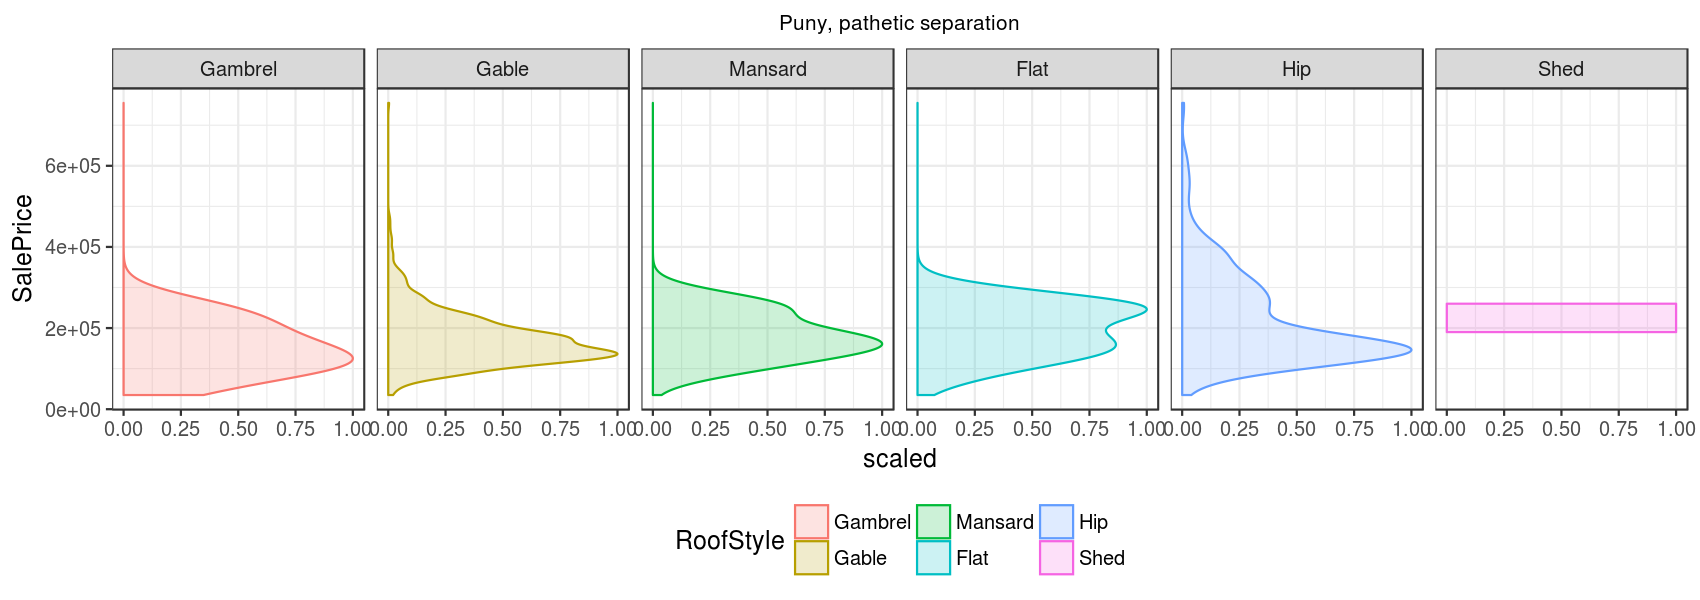

In [77]:
df = attr_sel.order_factor_by_target(categ_data, 'RoofStyle', 'SalePrice')

with Plot(width=1700, height=600, res=150) as plot:
    plot(
        ggplot2.ggplot(df) +
        ggplot2.aes_string(x='SalePrice', color='RoofStyle') +
        ggplot2.geom_density(ggplot2.aes_string(y='..scaled..', fill='RoofStyle'), alpha=0.2) +
        ggplot2.facet_wrap(robjects.Formula('~ RoofStyle'), nrow=1) +
        ggplot2.coord_flip() +
        ggplot2.theme_bw() +
        ggplot2.theme(**{'legend.position': 'bottom', 'plot.title': ggplot2.element_text(hjust = 0.5)}) +
        ggplot2.labs(title = "Puny, pathetic separation")
    ) 

### Ordering factors by $R^2$ of $log(SalePrice) \sim factor$

In [27]:
# For consintency with R __missing__ coding is replaced to NaN. 
# That will make statsmodels' to drop out NaN observations exactly like it is done in R.
categ_vars_by_r2 = attr_sel.arrange_vars_by_r2(
    categ_data.replace('__missing__', np.NaN), 
    'SalePrice'
)

numeric_vars_by_r2 = attr_sel.arrange_vars_by_r2(numeric_data, 'SalePrice')

In [28]:
categ_vars_by_r2.head(8)

,var,r2
0,Utilities,0.000205
1,Street,0.001684
2,LandSlope,0.002682
3,MoSold,0.007224
4,BsmtFinType2,0.009452
5,Condition2,0.009899
6,Heating,0.014437
7,Functional,0.016480


In [29]:
categ_vars_by_r2.tail(8)

,var,r2
37,Foundation,0.256368
38,GarageFinish,0.267276
39,Alley,0.285497
40,PoolQC,0.448651
41,BsmtQual,0.453756
42,KitchenQual,0.456599
43,ExterQual,0.477388
44,Neighborhood,0.545575


In [30]:
numeric_vars_by_r2.head(8)

,var,r2
0,BsmtFinSF2,0.000129
1,BsmtHalfBath,0.000284
2,MiscVal,0.000449
3,LowQualFinSF,0.000656
4,YrSold,0.000837
5,3SsnPorch,0.001988
6,OverallCond,0.006062
7,PoolArea,0.008538


In [31]:
numeric_vars_by_r2.tail(8)

,var,r2
26,TotRmsAbvGrd,0.284860
27,FullBath,0.314344
28,1stFlrSF,0.367057
29,TotalBsmtSF,0.376481
30,GarageArea,0.388667
31,GarageCars,0.410124
32,GrLivArea,0.502149
33,OverallQual,0.625652


# By Fisher statistics

For datailed comparison with R look at `learn/anova_separation` notebook.

In [32]:
df = (
    categ_data
    .assign(
        price_log = lambda df: np.log(df['SalePrice'])
    )
    .drop('SalePrice', 1)
)

anova = attr_sel.Anova(df, 'price_log')

q_table = anova.Q_table()
q_table.head()

# control
# should be close to zero
np.max((q_table['Q_total'] - (q_table['Q_within_groups'] + q_table['Q_of_groups'])))

,var,Q_of_groups,Q_total,Q_within_groups,num_levels,num_observ
0,Alley,6.433964,232.800659,226.366695,3.0,1460.0
1,BldgType,9.344708,232.800659,223.455951,5.0,1460.0
2,BsmtCond,20.169471,232.800659,212.631188,5.0,1460.0
3,BsmtExposure,33.195897,232.800659,199.604762,5.0,1460.0
4,BsmtFinType1,52.998896,232.800659,179.801763,7.0,1460.0


1.4779288903810084e-12

In [33]:
categ_vars_by_fisher = anova.arrange_vars()

In [34]:
categ_vars_by_fisher.head()

,var,F
44,Utilities,0.232689
35,MoSold,0.993740
28,LandSlope,1.083039
9,Condition2,2.527740
34,MiscFeature,3.621236


In [35]:
categ_vars_by_fisher.tail()

,var,F
7,CentralAir,205.666987
20,GarageFinish,298.769753
6,BsmtQual,300.392324
26,KitchenQual,393.320196
12,ExterQual,415.303357


# Discarding weak categorical variables

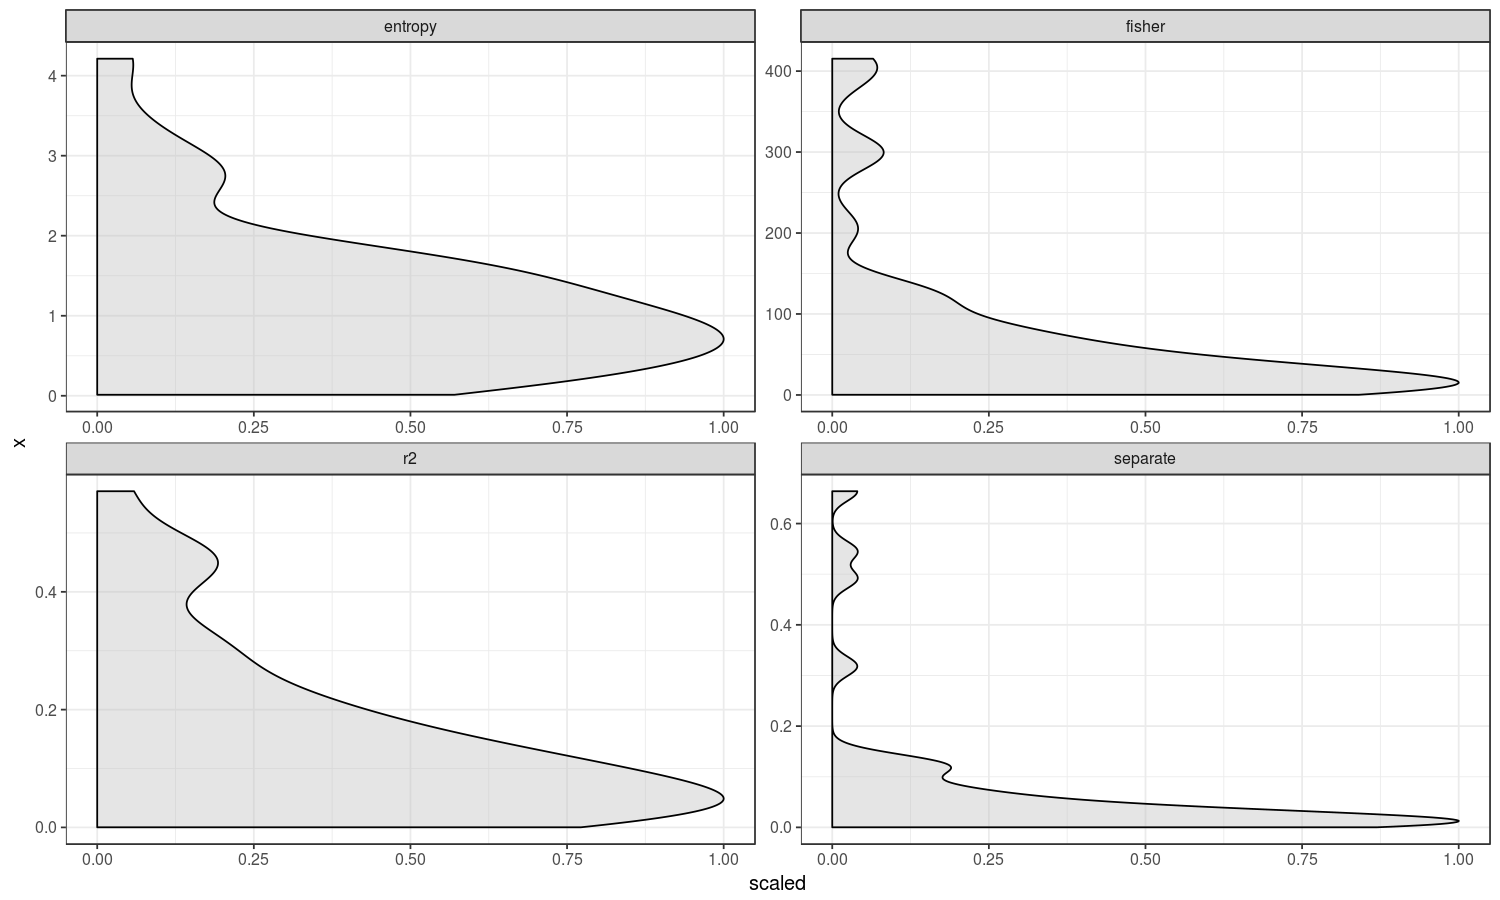

In [36]:
df = (
    categ_data
    .assign(
        price_log = lambda df: np.log(df['SalePrice'])
    )
    .drop('SalePrice', 1)
)

cat_by_entropy = attr_sel.arrange_vars_by_entropy(df.drop('price_log', 1))
cat_by_groups_separation = attr_sel.GroupsSeparation(df, 'price_log').arrange_vars()
cat_by_r2 = attr_sel.arrange_vars_by_r2(df.replace('__missing__', np.NaN), 'price_log')
cat_by_fisher = attr_sel.Anova(df, 'price_log').arrange_vars()

df_ggplot = pd.concat([
    cat_by_entropy.assign(method = 'entropy').rename(columns={'entropy': 'x'}),
    cat_by_groups_separation.assign(method = 'separate').rename(columns={'score': 'x'}),
    cat_by_r2.assign(method = 'r2').rename(columns={'r2': 'x'}),
    cat_by_fisher.assign(method = 'fisher').rename(columns={'F': 'x'}),
])

with Plot(width=1500, height=900, res=120) as plot:
    plot(
        ggplot2.ggplot(df_ggplot) +
        ggplot2.aes_string(x='x') +
        ggplot2.geom_density(ggplot2.aes_string(y='..scaled..'), alpha=0.4, fill='grey') +
        ggplot2.facet_wrap(robjects.Formula('~method'), nrow=2, ncol=2, scales = "free") +
        ggplot2.coord_flip() +
        ggplot2.theme_bw()
    ) 

In [37]:
x1 = cat_by_entropy.query('entropy < 1')['var']
x2 = cat_by_groups_separation.query('score < 0.2')['var']
x3 = cat_by_r2.query('r2 < 0.1')['var']
x4 = cat_by_fisher.query('F < 100')['var']

cat_virgin_vars = set.intersection(set(x1), set(x2), set(x3), set(x4))
cat_chad_vars = set(categ_data) - cat_virgin_vars

str(sorted(list(cat_virgin_vars)))
str(sorted(list(cat_chad_vars)))

"['BldgType', 'BsmtCond', 'BsmtFinType2', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'Functional', 'GarageCond', 'GarageQual', 'Heating', 'LandContour', 'LandSlope', 'PavedDrive', 'RoofMatl', 'RoofStyle', 'Street', 'Utilities']"

"['Alley', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'CentralAir', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'GarageFinish', 'GarageType', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'MoSold', 'Neighborhood', 'PoolQC', 'SaleCondition', 'SalePrice', 'SaleType']"

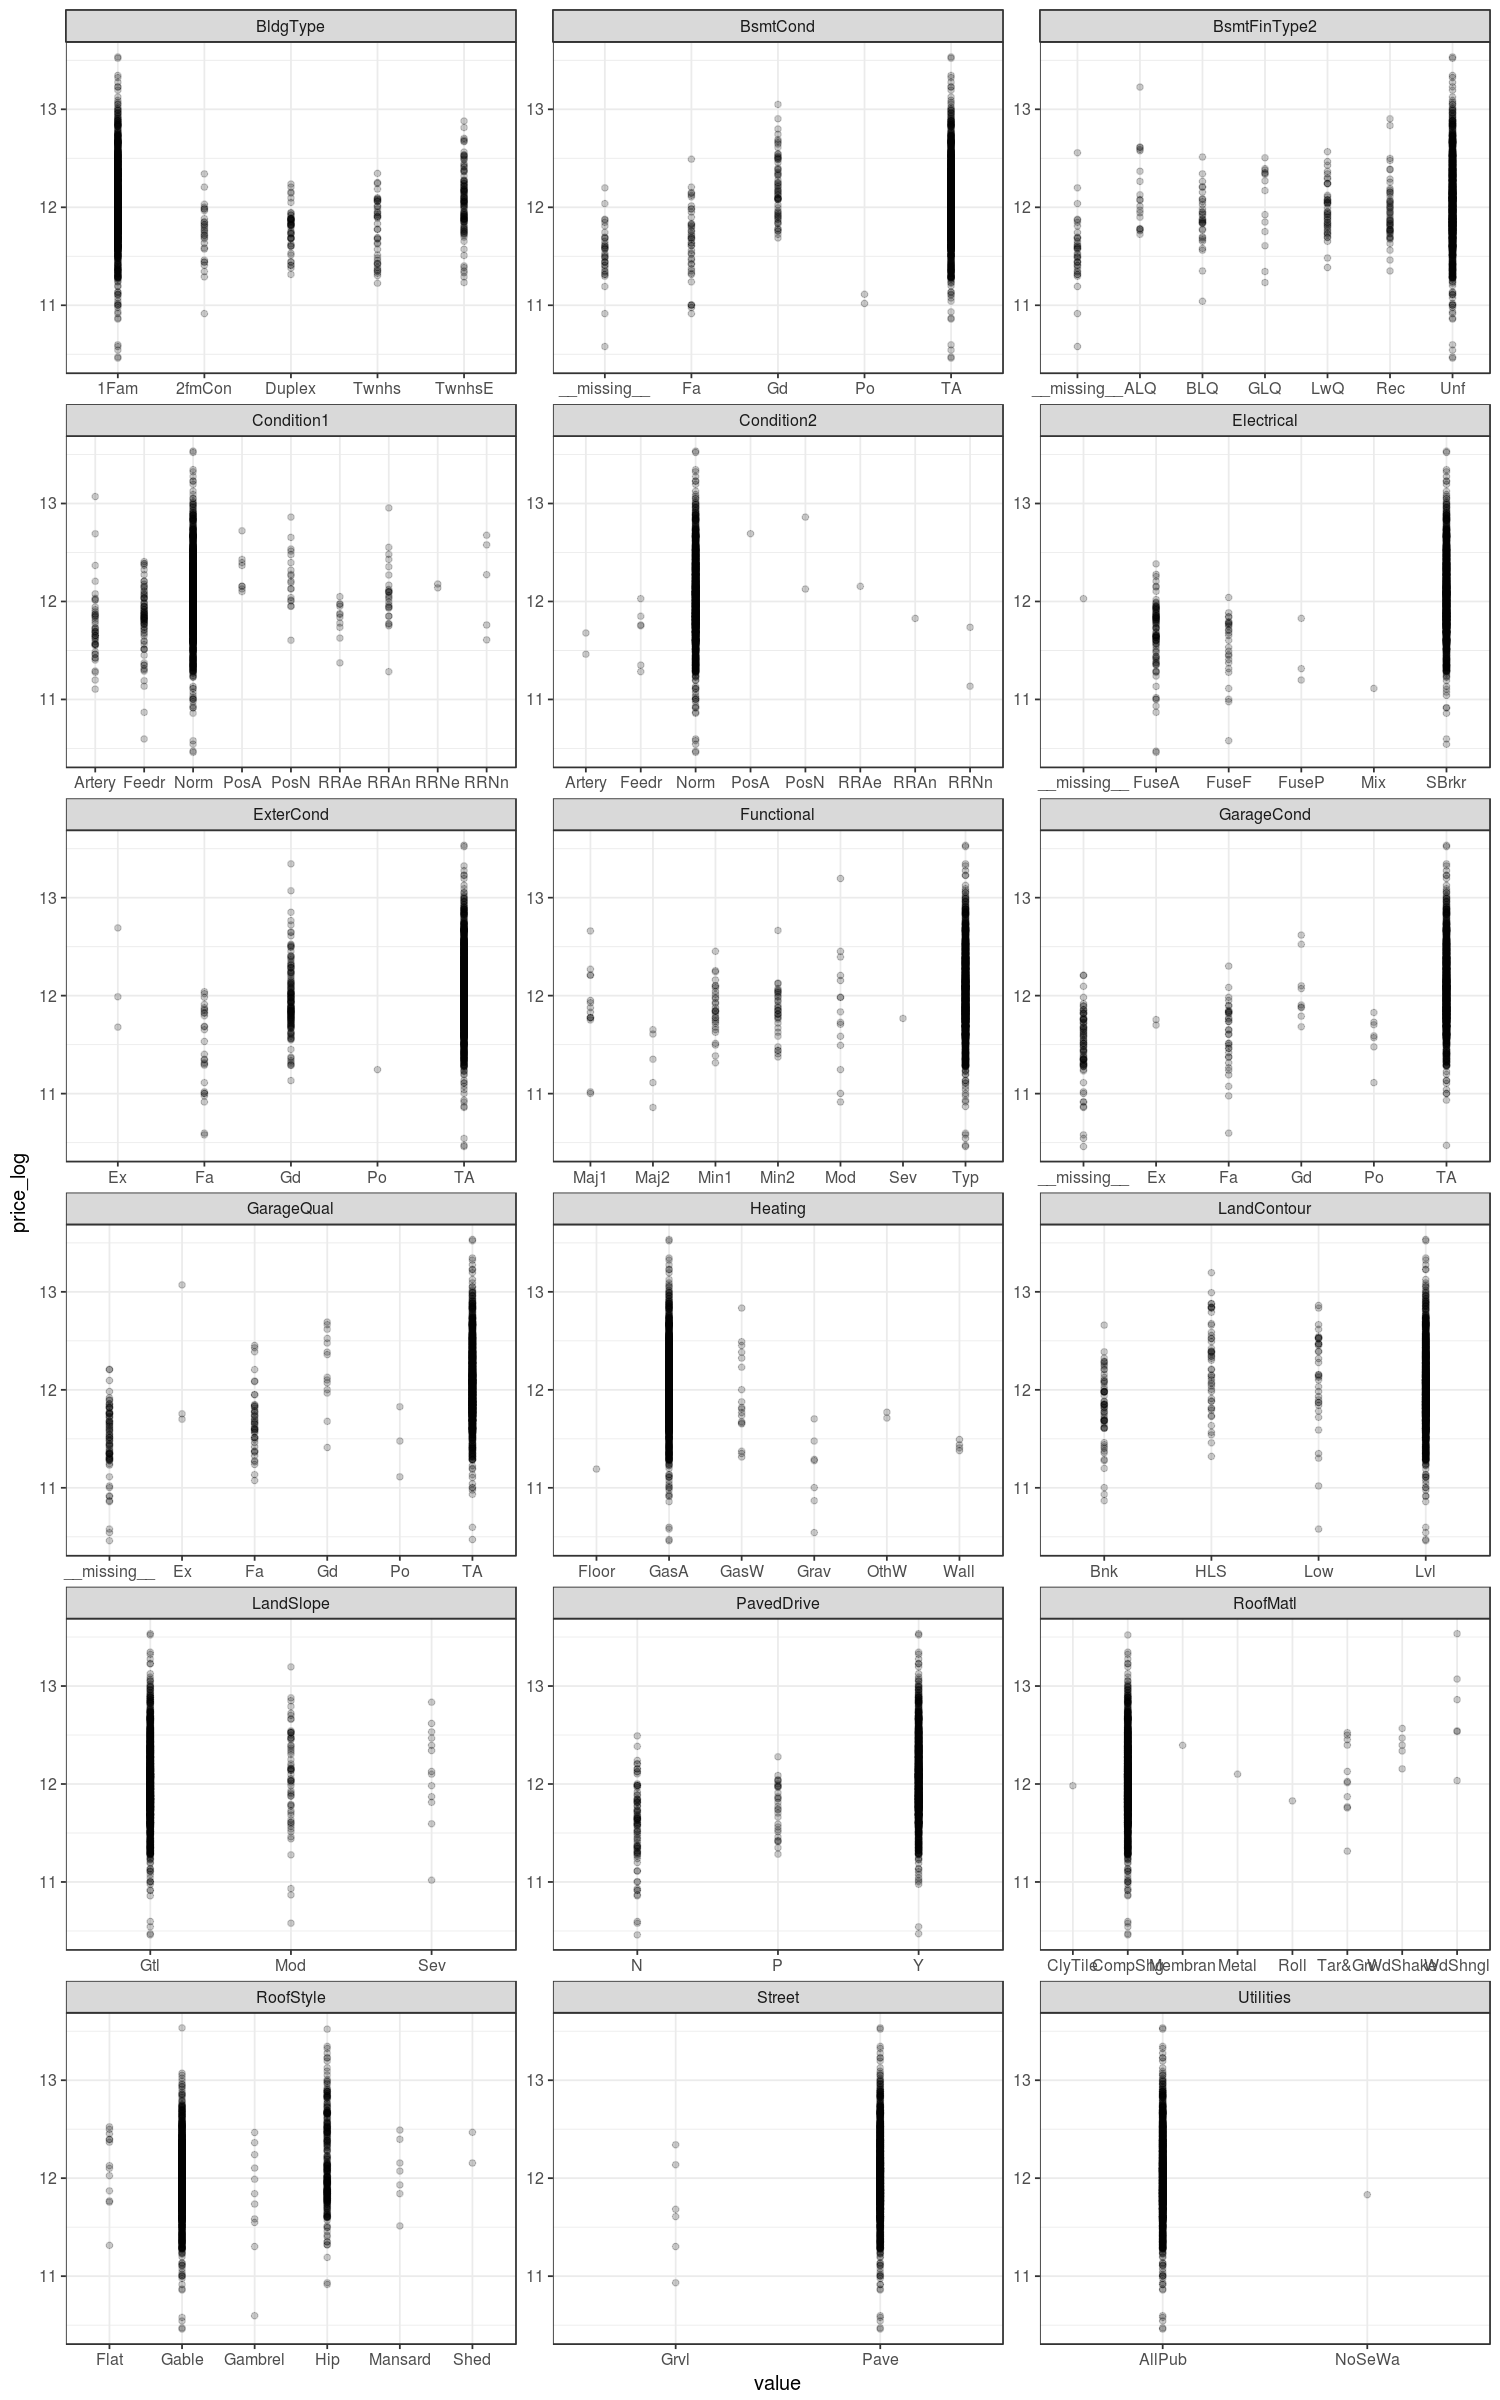

In [38]:
df = pd.melt(
    (
        categ_data
        .dropna(subset=['SalePrice'])
        .assign(price_log = lambda df: np.log(df['SalePrice']))
        [list(cat_virgin_vars | set(['price_log']))]
    ),
    id_vars=['price_log'],
    var_name='var', 
    value_name='value'
)

with Plot(width=1500, height=2400, res=120) as plot:
    plot(
        ggplot2.ggplot(df) +
        ggplot2.aes_string(x='value', y='price_log') +
        ggplot2.geom_point(alpha = 0.2) +
        ggplot2.facet_wrap(robjects.Formula('~var'), ncol=3, scale="free") +
        ggplot2.theme_bw()
    ) 

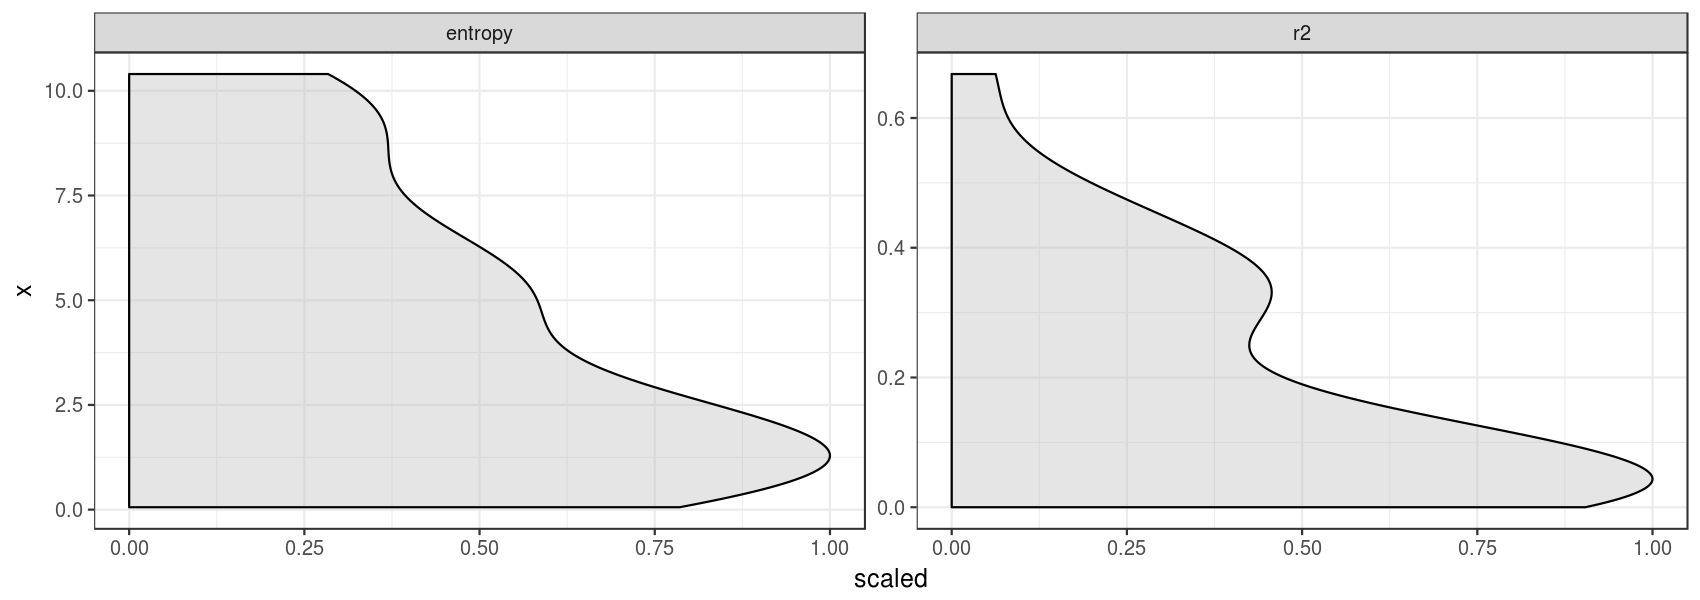

In [44]:
df = (
    numeric_data
    .assign(
        price_log = lambda df: np.log(df['SalePrice'])
    )
    .drop('SalePrice', 1)
)

num_by_entropy = attr_sel.arrange_vars_by_entropy(df)
num_by_r2 = attr_sel.arrange_vars_by_r2(df, 'price_log')

df_ggplot = pd.concat([
    num_by_entropy.assign(method = 'entropy').rename(columns={'entropy': 'x'}),
    num_by_r2.assign(method = 'r2').rename(columns={'r2': 'x'}),
])

with Plot(width=1700, height=600, res=150) as plot:
    plot(
        ggplot2.ggplot(df_ggplot) +
        ggplot2.aes_string(x='x') +
        ggplot2.geom_density(ggplot2.aes_string(y='..scaled..'), alpha=0.4, fill='grey') +
        ggplot2.facet_wrap(robjects.Formula('~method'), nrow=1, ncol=2, scales = "free") +
        ggplot2.coord_flip() +
        ggplot2.theme_bw()
    ) 

In [40]:
x1 = num_by_entropy.query('entropy < 2')['var']
x2 = num_by_r2.query('r2 < 0.1')['var']

num_virgin_vars = set(x1) & set(x2)
num_chad_vars = set(numeric_data) - num_virgin_vars

str(sorted(list(num_virgin_vars)))
str(sorted(list(num_chad_vars)))

"['3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'EnclosedPorch', 'HalfBath', 'KitchenAbvGr', 'LowQualFinSF', 'MiscVal', 'OverallCond', 'PoolArea', 'ScreenPorch']"

"['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallQual', 'SalePrice', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']"

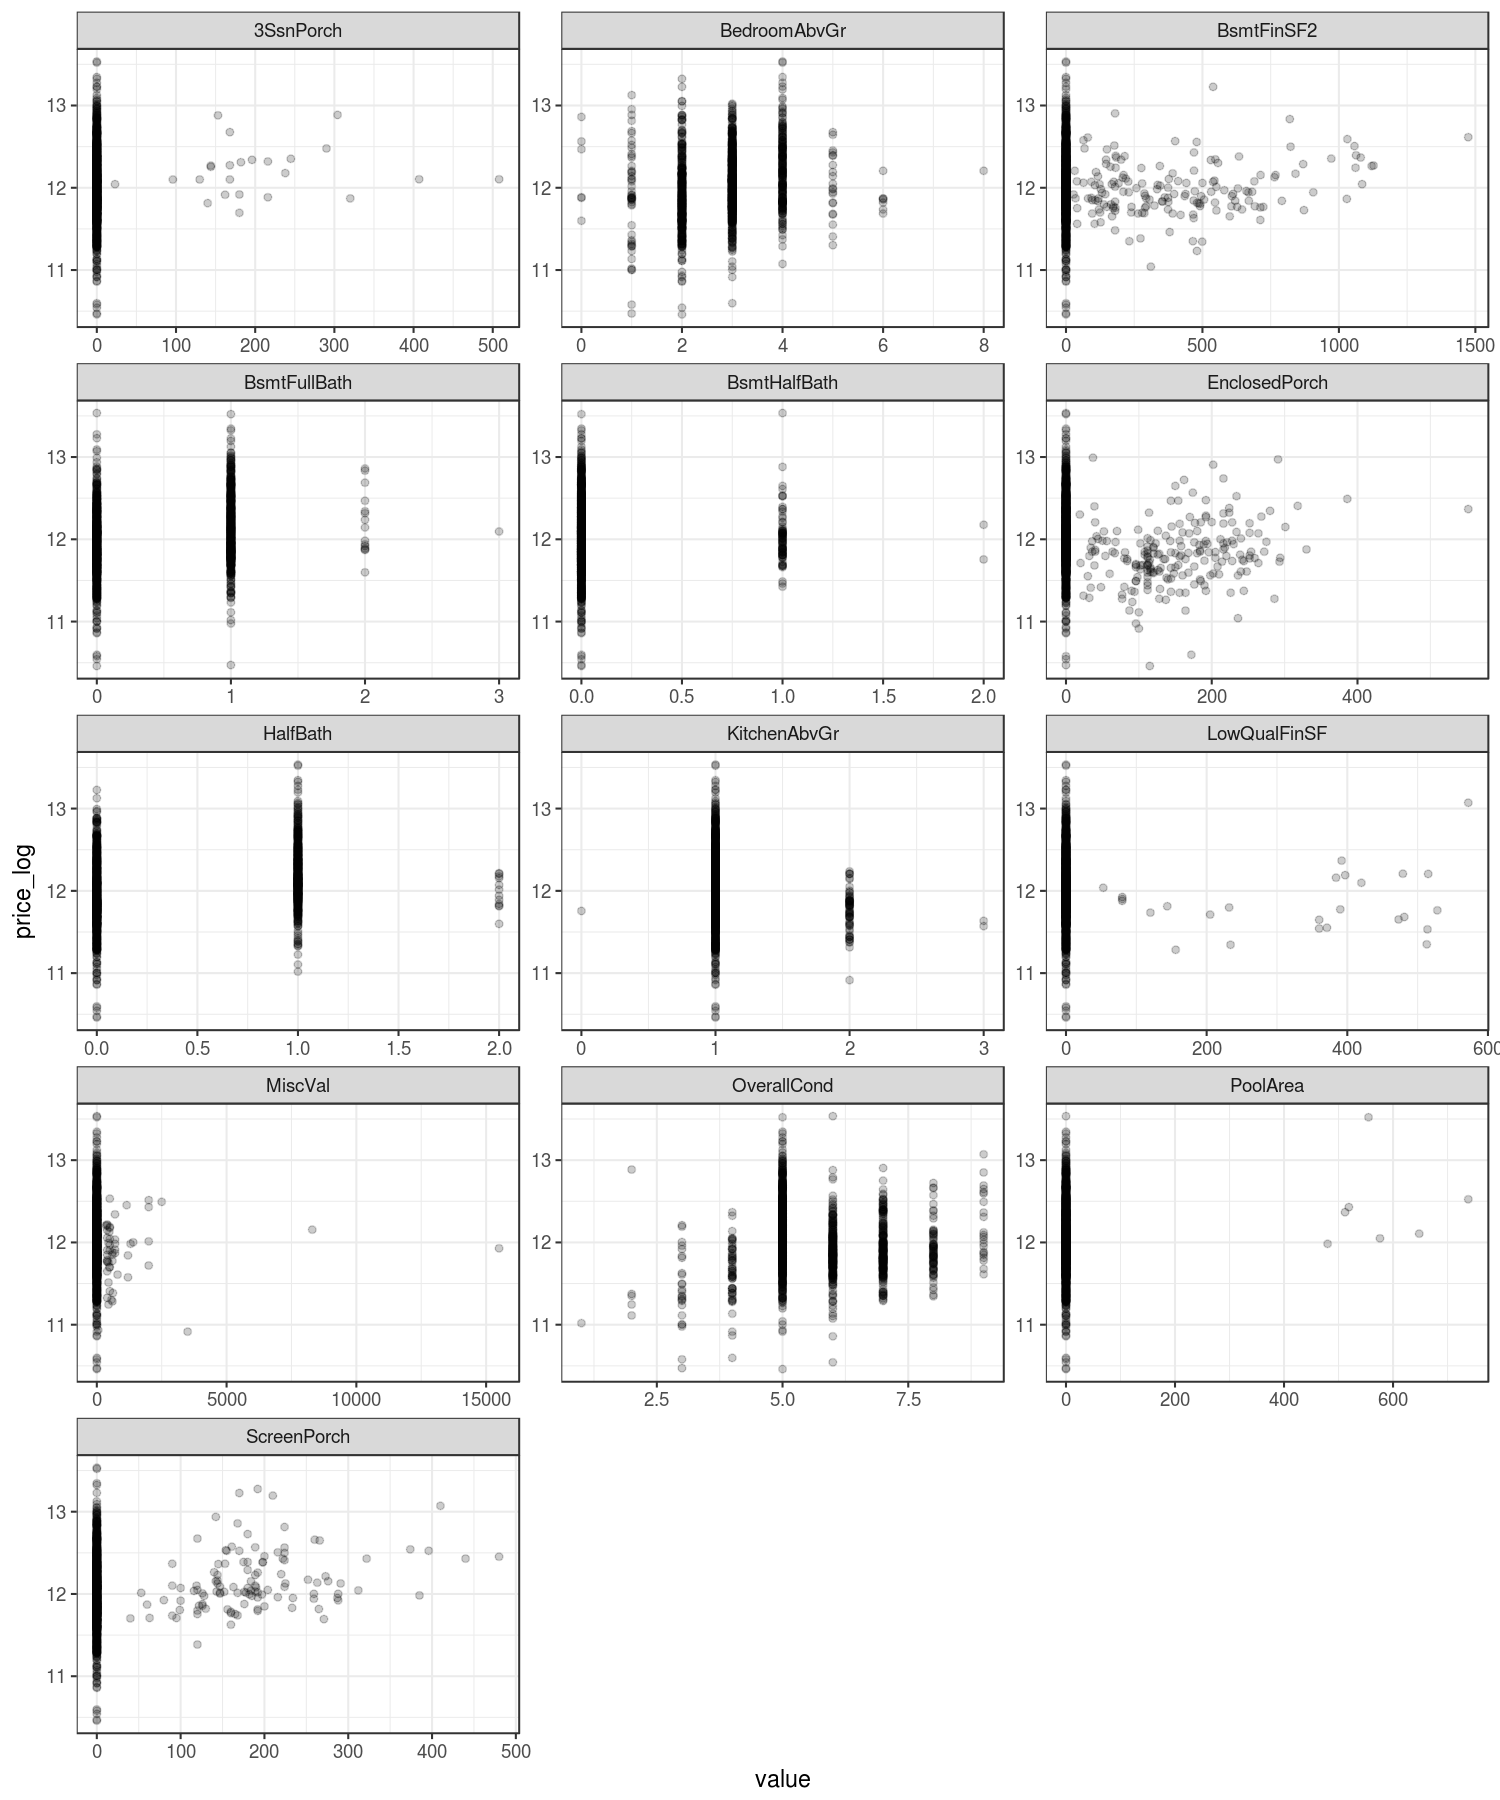

In [41]:
df = pd.melt(
    (
        numeric_data
        .dropna(subset=['SalePrice'])
        .assign(price_log = lambda df: np.log(df['SalePrice']))
        [list(num_virgin_vars | set(['price_log']))]
    ),
    id_vars=['price_log'],
    var_name='var', 
    value_name='value'
)

with Plot(width=1500, height=1800, res=140) as plot:
    plot(
        ggplot2.ggplot(df) +
        ggplot2.aes_string(x='value', y='price_log') +
        ggplot2.geom_point(alpha = 0.2) +
        ggplot2.facet_wrap(robjects.Formula('~var'), ncol=3, scale="free") +
        ggplot2.theme_bw()
    ) 